In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


from lobib import DataLoader

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

def save_fig(name):
    plt.savefig(f"../figures/fit/{name}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/fit/{name}.png", bbox_inches='tight', dpi=150)


HOURS_PER_DAY = 5.5
DAY_NS = int(5.5 * 3600 * 1e9)  # 5.5 hours in nanoseconds
HOUR_NS = int(3600 * 1e9)
TICK_TO_USD = 0.01
FIVE_MIN_NS = int(5 * 60 * 1e9)

In [2]:
loader = DataLoader()

def preprocess(df: pl.LazyFrame) -> pl.LazyFrame:
    """Preprocess raw order book data for estimation."""
    # Filter valid events (removed spread <= 4 filter)
    df = df.filter(
        pl.col("event_side")
        .replace({"A": 1, "B": -1})
        .cast(int)
        .mul(pl.col("event_queue_nbr"))
        >= 0
    )

    # Filter rows with best_bid_nbr and best_ask_nbr in expected range
    df = df.filter(
        pl.col("best_bid_nbr").is_between(-10, -1)
        & pl.col("best_ask_nbr").is_between(1, 10)
    )
    df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
    df = df.with_columns(pl.col("P_1").add(pl.col("P_-1")).truediv(2).alias("mid"))

    return df
    
def load_data(ticker: str) -> pl.LazyFrame:
    """Load raw order book data for a ticker."""
    info = loader.ticker_info(ticker)
    df = loader.load(
        ticker,
        start_date=info["date"].min(),
        end_date=info["date"].max(),
        schema="qr",
    ).sort(["date", "ts_event"])
    return preprocess(df)

def compute_eta(df: pl.LazyFrame) -> pl.DataFrame:
  """Compute eta per trading day."""
  return (
      df
      .with_columns(
          pl.col("mid").diff().over("date").alias("mid_diff")
      )
      .with_columns(
          pl.col("mid_diff").sign().alias("sign"),
          pl.col("mid_diff").sign().shift(1).over("date").alias("prev_sign")
      )
      .filter(pl.col("mid_diff").ne(0) & pl.col("prev_sign").is_not_null() & pl.col("prev_sign").ne(0))
      .with_columns(
          (pl.col("sign") == pl.col("prev_sign")).alias("is_continuation"),
          (pl.col("sign") != pl.col("prev_sign")).alias("is_alternation")
      )
      .group_by("date")
      .agg(
          pl.col("is_continuation").sum().alias("n_continuations"),
          pl.col("is_alternation").sum().alias("n_alternations")
      )
      .with_columns(
          (pl.col("n_continuations") / (2 * pl.col("n_alternations"))).alias("eta")
      ).collect(engine="streaming")
  )

# def compute_volatility(df: pl.LazyFrame) -> pl.DataFrame:
#     return (
#       df
#       .with_columns((pl.col("mid") * TICK_TO_USD).diff().over("date").alias("mid_diff"))
#       .filter(pl.col("mid_diff").is_not_null())
#       .group_by("date")
#       .agg((pl.col("mid_diff") ** 2).sum().alias("realized_var"))
#       .with_columns(
#           (pl.col("realized_var") / HOURS_PER_DAY).sqrt().alias("volatility_per_hour")
#       )
#       .collect(engine="streaming")
#     )

def compute_volatility_sampled_empirical(df: pl.LazyFrame, sample_interval_ns: int = FIVE_MIN_NS) -> pl.DataFrame:
  return (
      df
      .filter(pl.col("event") == "Trd")
      .with_columns(
          (pl.col("ts_event").dt.epoch("ns") // sample_interval_ns).alias("time_bucket")
      )
      .group_by(["date", "time_bucket"])
      .agg(pl.col("price").last())
      .sort(["date", "time_bucket"])
      .with_columns(
          (pl.col("price") * TICK_TO_USD).diff().over("date").alias("price_diff")
      )
      .filter(pl.col("price_diff").is_not_null())
      .group_by("date")
      .agg((pl.col("price_diff") ** 2).sum().alias("realized_var"))
      .with_columns(
          (pl.col("realized_var") / HOURS_PER_DAY).sqrt().alias("volatility_per_hour")
      )
      .collect(engine="streaming")
  )

def compute_volatility_sampled_simulation(df: pl.LazyFrame, sample_interval_ns: int = FIVE_MIN_NS) -> pl.DataFrame:
  return (
      df
      .filter(pl.col("event") == "Trade")
      .with_columns(
          (pl.col("ts_event") // sample_interval_ns).alias("time_bucket"),
          (pl.col("ts_event") // DAY_NS).alias("date")
      )
      .group_by(["date", "time_bucket"])
      .agg(pl.col("price").last())
      .sort(["date", "time_bucket"])
      .with_columns(
          (pl.col("price") * TICK_TO_USD).diff().over("date").alias("price_diff")
      )
      .filter(pl.col("price_diff").is_not_null())
      .group_by("date")
      .agg((pl.col("price_diff") ** 2).sum().alias("realized_var"))
      .with_columns(
          (pl.col("realized_var") / HOURS_PER_DAY).sqrt().alias("volatility_per_hour")
      )
      .collect(engine="streaming")
  )

In [9]:
def plot_vol_eta(ticker: str) -> None:
    df = load_data(ticker)
    eta = compute_eta(df)
    vol = compute_volatility_sampled_empirical(df)
    
    df_ = pl.scan_parquet(f"../data/results/{ticker}/result.parquet").filter(~pl.col("rejected"))
    df_ = df_.with_columns(
      (pl.col("ts_event") // DAY_NS).alias("date")
    )
    vol_ = compute_volatility_sampled_simulation(df_)
    eta_ = compute_eta(df_)
    
    # df__ = pl.scan_parquet(f"../data/results/{ticker}/result_totallvl.parquet").filter(~pl.col("rejected"))
    df__ = pl.scan_parquet(f"../data/results/{ticker}/result_alpha_no_impact_k1.0_race_theta0.03.parquet").filter(~pl.col("rejected"))
    df__ = df__.with_columns(
        (pl.col("ts_event") // DAY_NS).alias("date")
    )
    vol__ = compute_volatility_sampled_simulation(df__)
    eta__ = compute_eta(df__)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    colors = ["tab:blue", "tab:orange", "tab:green"]  # , "tab:green"]
    labels = ["Empirical", "QR", "Race"]  # , "QR 3D"]
    
    # Volatility
    vol_data = [
      vol["volatility_per_hour"].to_numpy(),
      vol_["volatility_per_hour"].to_numpy(),
      vol__["volatility_per_hour"].to_numpy()
    ]
    bp1 = ax1.boxplot(vol_data, patch_artist=True)
    for patch, color in zip(bp1["boxes"], colors):
      patch.set_facecolor(color)
      patch.set_alpha(0.7)
    ax1.set_ylabel(r"Volatility (USD / $\sqrt{\mathrm{hour}}$)")
    ax1.set_title(r"Realized Volatility (5-min sampled)")
    ax1.set_xticks([])
    
    # Eta
    eta_data = [
      eta["eta"].to_numpy(),
      eta_["eta"].to_numpy(),
      eta__["eta"].to_numpy()
    ]
    bp2 = ax2.boxplot(eta_data, patch_artist=True)
    for patch, color in zip(bp2["boxes"], colors):
      patch.set_facecolor(color)
      patch.set_alpha(0.7)
    ax2.set_ylabel(r"$\eta$")
    ax2.set_title(r"$\eta = N_{\mathrm{cont}} \,/\, 2 N_{\mathrm{alt}}$")
    ax2.set_xticks([])
    
    # Legend
    legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=c, alpha=0.7) for c in colors]
    fig.legend(legend_patches, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout()
    plt.suptitle(f"Ticker: {ticker}", y=1.02)
    plt.show()

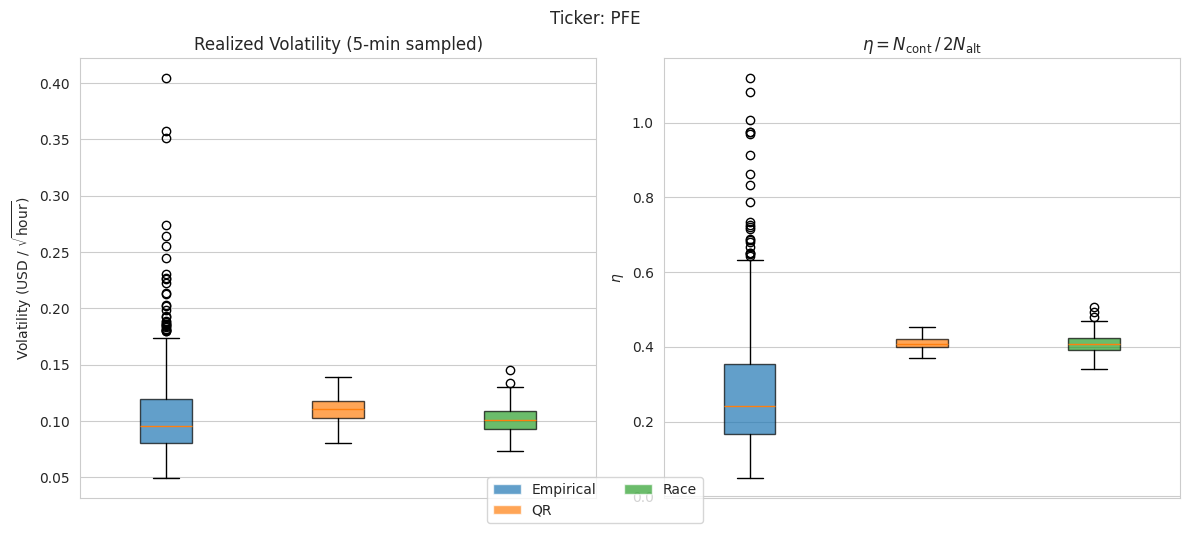

In [10]:
plot_vol_eta("PFE")

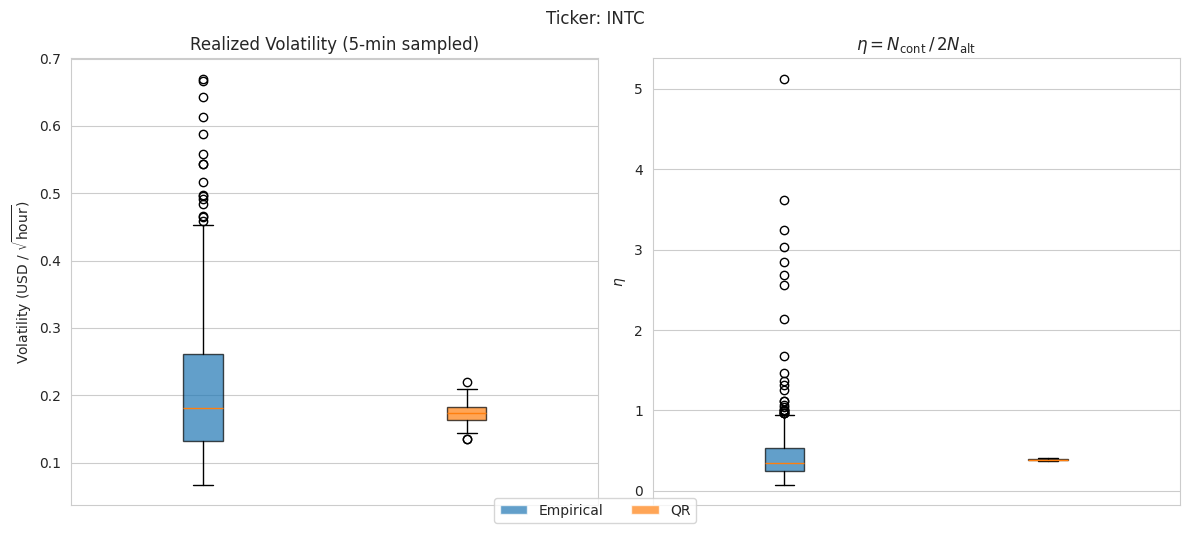

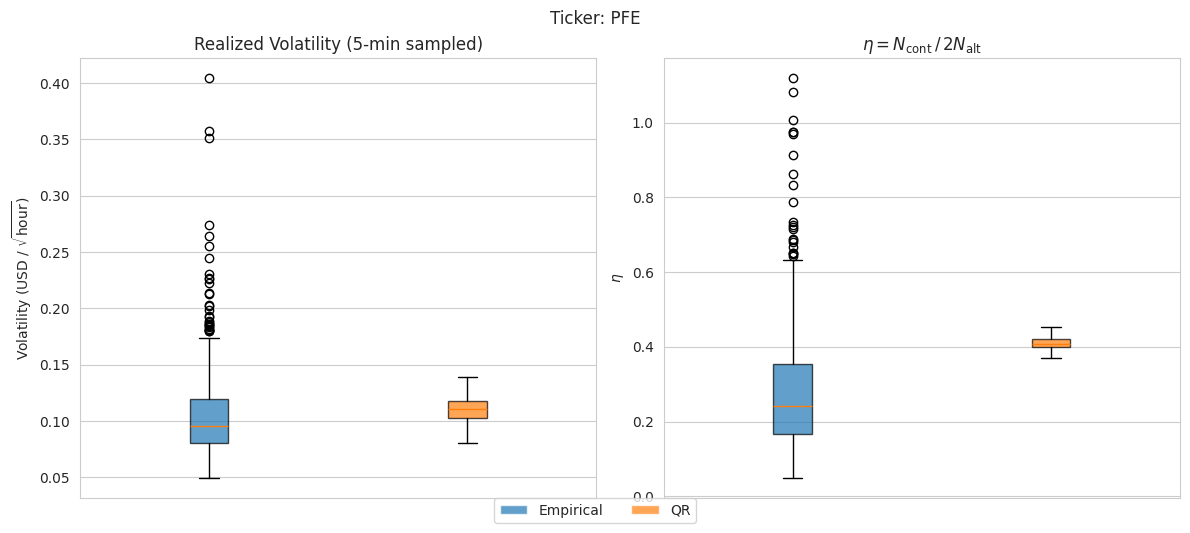

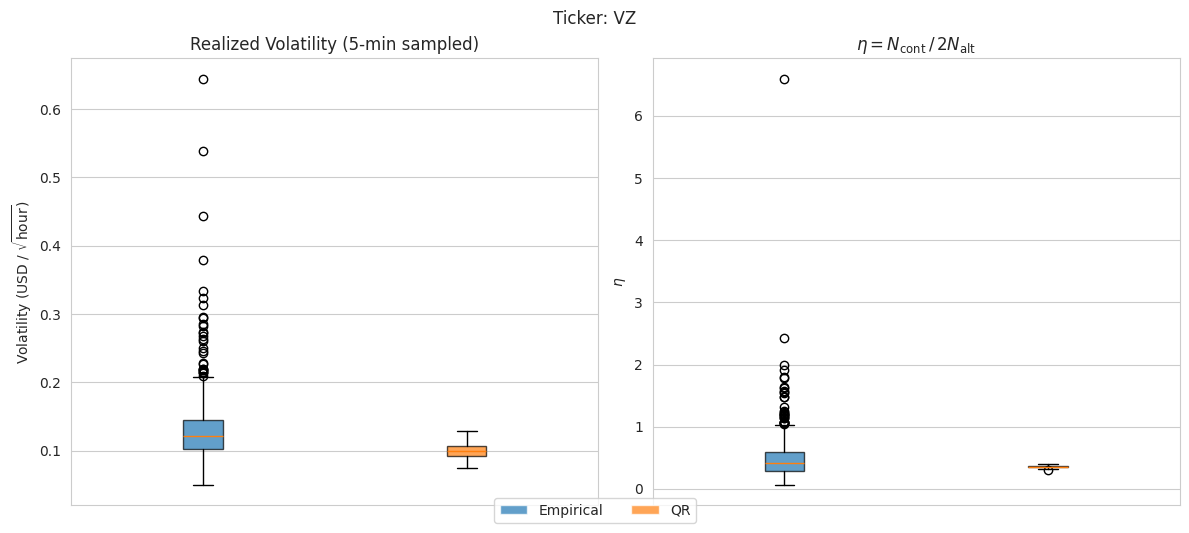

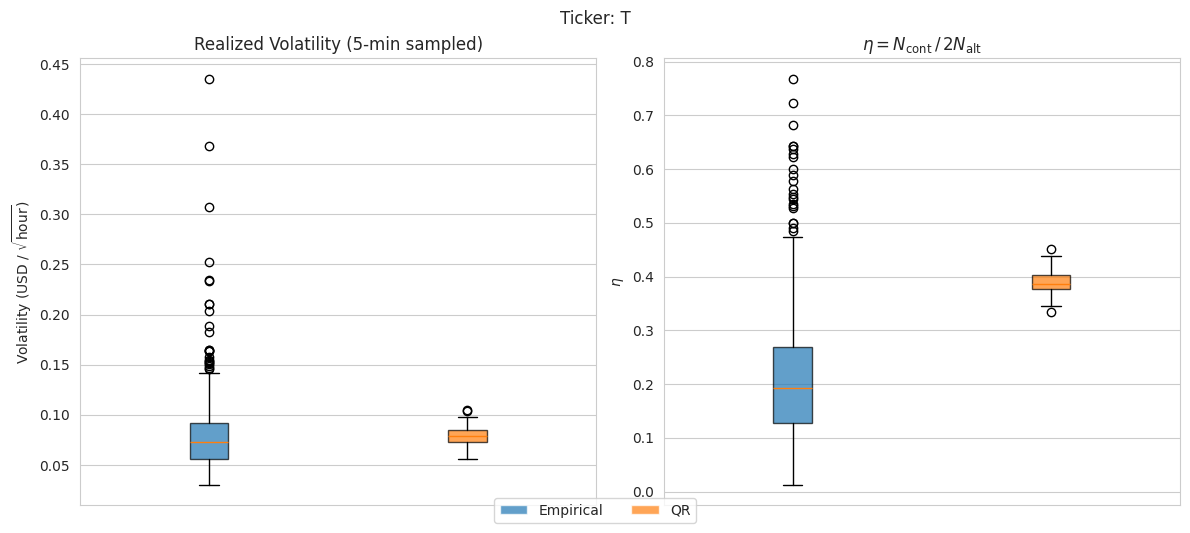

In [8]:
for ticker in ["INTC", "PFE", "VZ", "T"]:
    plot_vol_eta(ticker)

In [3]:
df = pl.read_parquet("/home/labcmap/saad.souilmi/dev_cpp/qr/data/results/PFE/aggressive_thresh0.50_qmax10_norace_trades.parquet")

In [8]:
df.filter(~pl.col("rejected"))

timestamp,inventory,side,size,price,rejected,pnl
i64,i32,i8,i32,i32,bool,f64
